# Recommendation System 

# Contents

# Business Understanding

# Data Understanding

In [1]:
import pandas as pd

ratings_df = pd.read_csv('Data/ratings.csv')
movies_df = pd.read_csv('Data/movies.csv')
tags_df = pd.read_csv('Data/tags.csv')

In [2]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
ratings_df.shape

(100836, 4)

In [4]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [5]:
#Checking NaN counts in ratings_df
nan_count = ratings_df.isna().sum()
nan_count

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [6]:
# Using Pandas pivot table to create the user-item interaction matrix
user_item_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating')
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Fill all NaN values with 0
user_item_matrix = user_item_matrix.fillna(0)

In [8]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Baseline model: 'ratings_df' matrix factorization with SVD

#### Matrix Factorization using Singular Value Decomposition (SVD)

Matrix factorization is a powerful technique used in recommendation systems and dimensionality reduction. It allows us to decompose a large matrix into three smaller matrices to reveal latent factors or patterns in the data. Singular Value Decomposition (SVD) is a popular method for achieving this factorization.

#### What is SVD?

SVD is a mathematical technique used to factorize a matrix into three component matrices, which can be thought of as encoding underlying structures in the data. These three matrices are:

- U (User Matrix): Represents the relationships between users and latent factors.
- Σ (Singular Value Matrix): Contains the singular values that represent the importance of each latent factor.
- Vᵀ (Item Matrix): Represents the relationships between items (or features) and latent factors.

#### The Matrix Factorization Process

The goal of SVD-based matrix factorization is to approximate the original matrix (often representing user-item interactions, like ratings or clicks) by finding the product of these three matrices.

1. **Decomposition**: The original matrix is decomposed into three matrices: U, Σ, and Vᵀ. The Σ matrix is diagonal and contains singular values, while U and Vᵀ contain the user and item representations, respectively.

2. **Dimension Reduction**: You can choose to reduce the number of latent factors (dimensions) by selecting a subset of the singular values and their corresponding columns in U and rows in Vᵀ. This dimension reduction simplifies the data while retaining its most essential features.

3. **Reconstruction**: By multiplying the reduced U, Σ, and Vᵀ matrices, you can reconstruct an approximation of the original matrix. This approximation can be used to make predictions or recommendations.

#### Application in Recommendation Systems

In recommendation systems, the SVD-based matrix factorization technique can be used to predict user preferences for items. By decomposing the user-item interaction matrix and approximating it, we can identify latent factors that capture user preferences and item characteristics. These latent factors can be used to make personalized recommendations.

In this section, we will explore how to implement matrix factorization using SVD in Python and how to make recommendations based on the factorized matrices. Additionally, we will discuss evaluation metrics to assess the performance of recommendation systems.

Let's dive into the code and practical aspects of matrix factorization using SVD:


1. First, let's import the necessary libraries. We're importing the Singular Value Decomposition (SVD) function from `SciPy` and the `NumPy` library, which provides support for working with arrays and matrices. 
2. Next, we'll convert the user-item matrix from a DataFrame (`user_item_matrix`) to a NumPy array (`R`). The user-item matrix contains user ratings for movies, with users as rows and movies as columns. 
3. Then, we'll set the number of latent factors (also known as the number of dimensions) for the SVD. In this model, we're using 10 latent factors, which determines how many underlying patterns the SVD will consider.

In [9]:
from scipy.sparse.linalg import svds
import numpy as np

# Convert the user item matrix DataFrame to a NumPy array
R = user_item_matrix.values

# Number of latent factors
num_latent_factors = 10

4. The `svds` function performs Singular Value Decomposition on the user-item matrix `R`. It decomposes the matrix into three parts: `U`, `sigma`, and `Vt`.

    - `U` (user-feature matrix) is a matrix that represents users and their relationships with latent factors (features).
        - Each row of U corresponds to a user, and each column represents a latent factor.
        - It encodes how users are related to these latent factors, capturing user preferences and characteristics.
    - `sigma` (Σ) is a diagonal matrix that contains the singular values of the original user-item interaction matrix (often denoted as "R").
        - These singular values are non-negative and are sorted in descending order on the diagonal of Σ.
        - `sigma` provides information about the importance or strength of each latent factor in explaining the variance in the data.
        - The singular values at the top (largest) of the diagonal are the most important, while those at the bottom (smallest) are less important.
    - `Vt` (V transpose) is a matrix that represents movies and their relationships with latent factors.
        - Vt is the transposed matrix V.
        - V represents the "item-feature matrix" in the context of collaborative filtering.
        - Each row of Vt corresponds to an item (in our case, movies), and each column represents a latent feature.
        - Vt encodes the relationships between items and latent factors.
        - The columns of Vt provide information about how movies are associated with these latent factors.

    - The `k` parameter specifies the number of singular values and vectors to compute, which corresponds to the number of latent factors.

In [10]:
# Perform SVD
U, sigma, Vt = svds(R, k=num_latent_factors)

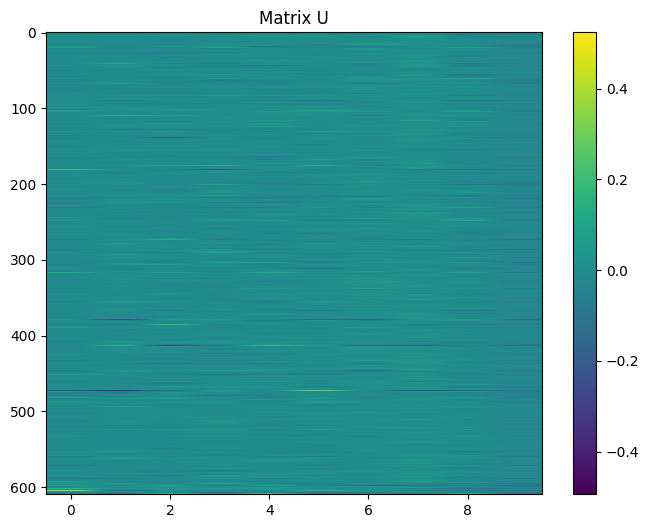

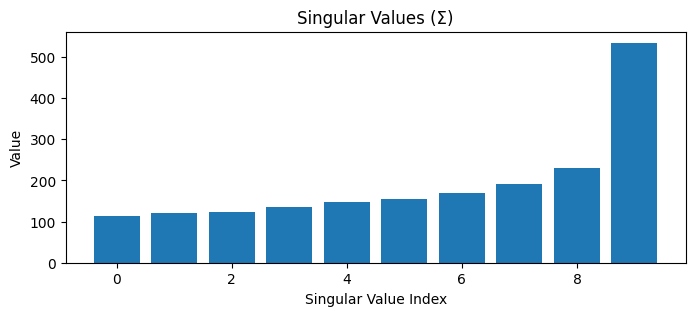

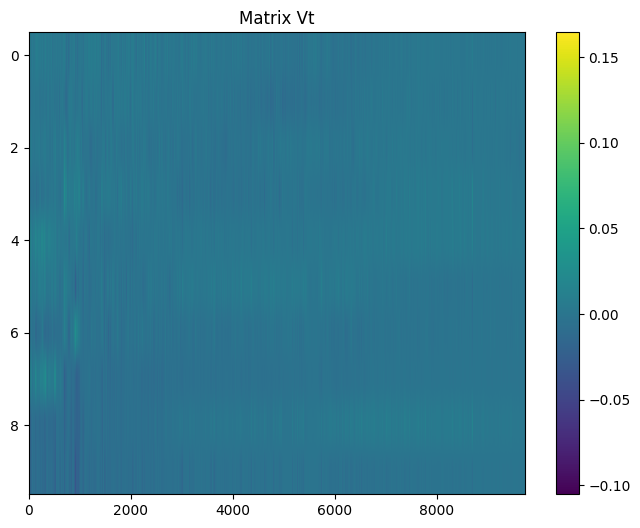

In [11]:
import matplotlib.pyplot as plt

# Visualize U
plt.figure(figsize=(8, 6))
plt.imshow(U, cmap='viridis', aspect='auto')
plt.title('Matrix U')
plt.colorbar()
plt.show()

# Visualize Σ (singular values)
plt.figure(figsize=(8, 3))
plt.bar(range(len(sigma)), sigma)
plt.title('Singular Values (Σ)')
plt.xlabel('Singular Value Index')
plt.ylabel('Value')
plt.show()

# Visualize Vt
plt.figure(figsize=(8, 6))
plt.imshow(Vt, cmap='viridis', aspect='auto')
plt.title('Matrix Vt')
plt.colorbar()
plt.show()

5. Next, we convert the diagonal matrix `sigma` into a standard diagonal matrix format. This is essential for later matrix multiplication.

In [12]:
# Convert sigma to a diagonal matrix
sigma = np.diag(sigma)

6. Now, we compute the predicted ratings for each user-movie pair using the SVD results. We multiply matrices `U`, `sigma`, and `Vt` using NumPy's dot function, which represents the prediction for each user-movie interaction.
7. Finally, we will convert the predicted ratings back into a DataFrame named `predicted_ratings_df`. This DataFrame now contains the predicted ratings for each user and movie, allowing us to use these predictions for making recommendations or further analysis. The columns and index of `predicted_ratings_df` are set to match the original user-item matrix for easy reference.

In [13]:
# Reconstruct the original matrix
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Convert the reconstructed matrix back to a DataFrame
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=user_item_matrix.columns, index=user_item_matrix.index)

In [14]:
# Defining a function to recommend the top N items for a specific user
def recommend_top_n(user_id, N=10):
    # Retrieve the predicted ratings for the user
    user_ratings = predicted_ratings_df.loc[user_id]

    # Sort the ratings in descending order and recommend the top N items
    top_n_recommendations = user_ratings.sort_values(ascending=False).head(N)

    return top_n_recommendations

In [15]:
user_id = 123  # Replace with the actual user's ID
top_n_recommendations = recommend_top_n(user_id, N=10)
print(top_n_recommendations)

movieId
318      2.491535
79132    2.031856
2571     2.016302
296      1.962429
356      1.944800
2959     1.887293
58559    1.869659
593      1.764870
7153     1.714801
858      1.587019
Name: 123, dtype: float64


Now, let's evaluate the predicted ratings score. First, we will use **Root Mean Squared Error (RMSE)**. The RMSE score measures the average prediction error of our recommendation system. A *lower* RMSE is desirable; the closer the RMSE is to 0, the better our recommendation system's predictions align with actual user ratings. An RMSE of 0 would mean that the predictions perfectly match the actual ratings.

In [16]:
from sklearn.metrics import mean_squared_error

# Assuming you have the predicted_ratings_df DataFrame with predicted ratings
# And you have a user-item rating matrix user_item_matrix with actual ratings

# Convert the predicted ratings DataFrame to a NumPy array
predicted_ratings = predicted_ratings_df.values

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(user_item_matrix.values, predicted_ratings))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.3751246546278618


Our RMSE score of ***0.3751*** indicates that, on average, the predicted ratings for movies are approximately 0.3751 units away from the actual ratings given by users.

Let's deploy one more accuracy metric: **Mean Absolute Error (MAE)**. MAE measures the average absolute difference between predicted ratings and actual user ratings. *Lower* MAE values are desirable, as they indicate that the predicted ratings are closer to the actual ratings. An MAE of 0 would imply that the predictions exactly match the actual ratings.

In [17]:
from sklearn.metrics import mean_absolute_error

# Assuming you have the predicted_ratings_df DataFrame with predicted ratings
# And you have a user-item rating matrix user_item_matrix with actual ratings

# Convert the predicted ratings DataFrame to a NumPy array
predicted_ratings = predicted_ratings_df.values

# Calculate the MAE
mae = mean_absolute_error(user_item_matrix.values, predicted_ratings)
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 0.10222344995629794


Our MAE of ***0.1022*** indicates that, on average, our recommendation system's predicted ratings deviate by about 0.1022 units from actual user ratings.